# Homework 2
## Extracting TopUniversities and TimesHigherEducation Data

## Library

In [69]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn
import unicodedata
import re
%matplotlib inline

## Vars

In [35]:
web_urls = [{'page':'https://www.topuniversities.com',
             'data':'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'},
            {'page':'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats',
             'data':'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'}]

#reading from pickle, avoid generating to many redundant traffic
qs_top200 = pd.read_pickle("qs_top200_pickle")
times_top200 = pd.read_pickle("times_top200_pickle")


## Functions

In [70]:
def get_number_elements(htmlPage, className):
    try:
        number = int(((htmlPage.find('div', class_=className)).find('div', class_="number").text).replace(',',''))    
    except AttributeError:
        number = 0
    return number

def crawl_topuniversities(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for idx,university in enumerate(universities):
        
        university_region = university['region']
        university_country = university['location']
        university_rank = university['overall_rank']
        
        university_info_html = BeautifulSoup(university['uni'], 'html.parser')
        link_element = university_info_html.find('a')
        
        university_name = link_element.text
        university_link = link_element.get('href')

        university_detail = requests.get(url['page']+university_link)
        university_detail_html = BeautifulSoup(university_detail.text, 'html.parser')
        
        n_f_members = get_number_elements(university_detail_html,"total faculty")    
        n_inter_f_members = get_number_elements(university_detail_html,"inter faculty") 
        
        n_students = get_number_elements(university_detail_html,"total student") 
        n_inter_students = get_number_elements(university_detail_html,"total inter") 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'region': university_region,
                                'total_faculty_members': n_f_members,
                                'total_international_faculty_members': n_inter_f_members,
                                'total_students': n_students,
                                'total_international_students': n_inter_students
                          })
        list_universities.append(university_data)
    
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities

def crawl_timeshighereducation(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for university in universities:
        
        university_rank = university['rank']
        university_name = university['name']
        university_country = university['location']
        n_students = int(university['stats_number_students'].replace(',',''))
        student_staff_ratio = float(university['stats_student_staff_ratio'])
        inter_student_percentage = float(university['stats_pc_intl_students'].strip('%'))/100 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'student_staff_ratio': student_staff_ratio,
                                'percentage_international_students': inter_student_percentage,
                                'total_students': n_students
                          })
        list_universities.append(university_data)
        
    universities = pd.DataFrame.from_dict(list_universities)
    return universities   

def group_df(df,group_category,agg):
    return df.groupby(group_category).university_name.agg([agg])

def convert_string(string):
    str_byte = unicodedata.normalize("NFKD",string).encode('ascii','ignore')
    string_ascii = str_byte.decode("utf-8", "strict")
    string_without_parentheses = (re.sub(r'\([^)]*\)', '', string_ascii)).strip()
    return string_without_parentheses

def df_convert_index(df):
    new_index = pd.Series(list(map(convert_string,df['university_name'])))
    new_df = df.drop(['university_name'],axis=1)
    new_df['university_name'] = new_index
    new_df = new_df.set_index(['university_name'])
    return new_df

## Main Homework

### 1.Analysis of Top Universities Data

In [12]:
qs_top200 = crawl_topuniversities(web_urls[0],200)

In [36]:
qs_top200.head()

,country,rank,region,total_faculty_members,total_international_faculty_members,total_international_students,total_students,university_name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology (Caltech)
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


#### 1a. Best Universities: Ratio Faculty Members / Students

In [37]:
f_members_students_r = pd.DataFrame(qs_top200.university_name)
f_members_students_r["faculty_member_student_ratio"] = (qs_top200.total_faculty_members/qs_top200.total_students)
f_members_students_r.sort_values("faculty_member_student_ratio",ascending=False).head(3)

,university_name,faculty_member_student_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292


#### 1b. Best Universities: International Student Ratio

In [38]:
inter_students_r = pd.DataFrame(qs_top200.university_name)
inter_students_r["international_student_ratio"] = (qs_top200.total_international_students/qs_top200.total_students)
inter_students_r.sort_values("international_student_ratio",ascending=False).head(3)

,university_name,international_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567


#### 1c. Best Universities by Country

In [59]:
qs_country_grouped = group_df(qs_top200,"country","count")

display(qs_country_grouped)

,count
country,
Argentina,1
Australia,9
Austria,2
Belgium,4
Brazil,2
Canada,7
Chile,1
China,7
Denmark,3


#### 1d. Best Universities by Region

In [60]:
qs_region_grouped = group_df(qs_top200,"region","count")

display(qs_region_grouped)

,count
region,
Africa,1
Asia,38
Europe,90
Latin America,6
North America,54
Oceania,11


#### Plot

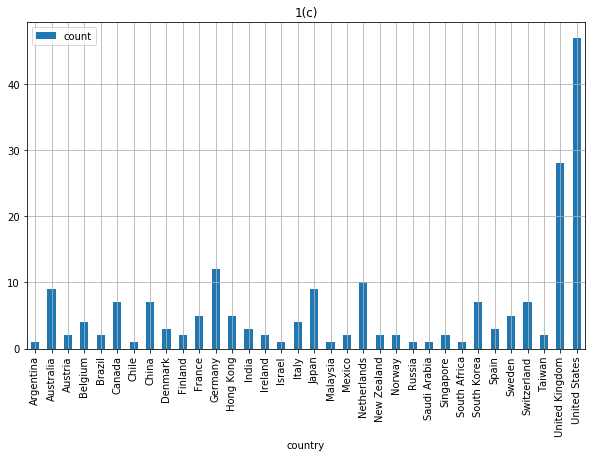

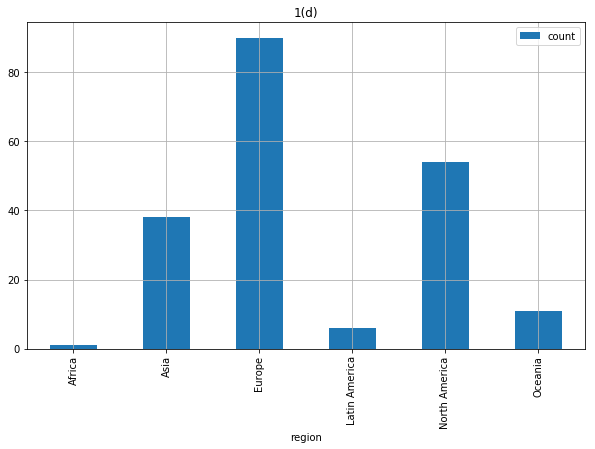

In [61]:
plot01=qs_country_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='1(c)')
plot02=qs_region_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='1(d)')

* Writing Data into a file

In [42]:
qs_top200.to_pickle("qs_top200_pickle")

### 2.Analysis of Times Higher Education Data

In [8]:
times_top200 = crawl_timeshighereducation(web_urls[1],200)

In [43]:
times_top200.head()

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,United Kingdom,0.38,1,11.2,20409,University of Oxford
1,United Kingdom,0.35,2,10.9,18389,University of Cambridge
2,United States,0.27,=3,6.5,2209,California Institute of Technology
3,United States,0.22,=3,7.5,15845,Stanford University
4,United States,0.34,5,8.7,11177,Massachusetts Institute of Technology


#### 2a. Best Universities: Student/Staff Ratio

In [44]:
times_top200.sort_values("student_staff_ratio",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
99,Germany,0.13,=100,77.9,35619,University of Bonn
124,Germany,0.16,125,74.5,10995,University of Mannheim
91,Germany,0.20,92,64.3,22390,Technical University of Berlin


#### 2b. Best Universities: International Student Ratio

In [45]:
times_top200.sort_values("percentage_international_students",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
24,United Kingdom,0.71,=25,12.2,10065,London School of Economics and Political Science
178,Luxembourg,0.57,=179,14.6,4969,University of Luxembourg
37,Switzerland,0.55,=38,11.2,9928,École Polytechnique Fédérale de Lausanne


#### 2c. Best Universities by Country

In [62]:
times_country_grouped = group_df(times_top200,"country","count")

display(times_country_grouped)

,count
country,
Australia,8
Austria,1
Belgium,4
Canada,6
China,7
Denmark,3
Finland,2
France,6
Germany,20


#### Plot

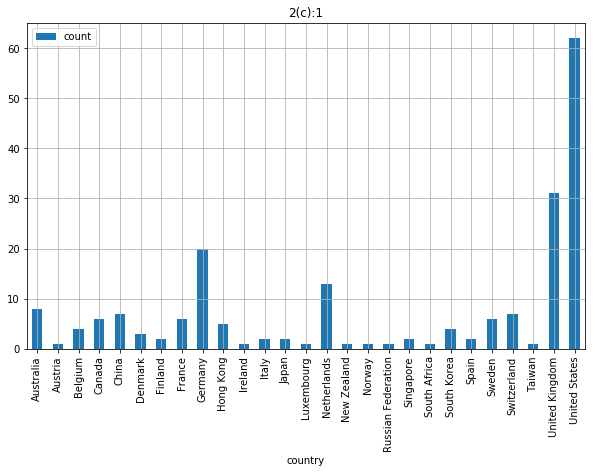

In [63]:
plot03=times_country_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='2(c):1')

* Writing Data into a file

In [34]:
times_top200.to_pickle("times_top200_pickle")

### 3.Merging Dataframe
#### We define 5 steps to match universities' name as much as we can

In [141]:
# Forming the dataframe df1 and df2
df1 = df_convert_index(qs_top200)
df1 = df1.add_prefix("qs_")

df2 = df_convert_index(times_top200)
df2 = df2.add_prefix("times_")

display(df1.head())
display(df2.head())

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067
Stanford University,United States,2,North America,4285,2042,3611,15878
Harvard University,United States,3,North America,4350,1311,5266,22429
California Institute of Technology,United States,4,North America,953,350,647,2255
University of Cambridge,United Kingdom,5,Europe,5490,2278,6699,18770


,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,
University of Oxford,United Kingdom,0.38,1,11.2,20409
University of Cambridge,United Kingdom,0.35,2,10.9,18389
California Institute of Technology,United States,0.27,=3,6.5,2209
Stanford University,United States,0.22,=3,7.5,15845
Massachusetts Institute of Technology,United States,0.34,5,8.7,11177


### Step 1: Exact Matching of University Name and Form the Rest of Dataframe1

In [142]:
# Merging step 1
# find matching index in df2 from df1
df1_matching_idx = (df1.index).isin(df2.index)

# forming with exact match
df_merged_exact_match = pd.concat([df1[df1_matching_idx], df2], axis=1, join='inner')

# the rest
df1_rest = df1[~df1_matching_idx]
df_merged_exact_match

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067,United States,0.34,5,8.7,11177
Stanford University,United States,2,North America,4285,2042,3611,15878,United States,0.22,=3,7.5,15845
Harvard University,United States,3,North America,4350,1311,5266,22429,United States,0.26,6,8.9,20326
California Institute of Technology,United States,4,North America,953,350,647,2255,United States,0.27,=3,6.5,2209
University of Cambridge,United Kingdom,5,Europe,5490,2278,6699,18770,United Kingdom,0.35,2,10.9,18389
University of Oxford,United Kingdom,6,Europe,6750,2964,7353,19720,United Kingdom,0.38,1,11.2,20409
Imperial College London,United Kingdom,8,Europe,3930,2071,8746,16090,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,9,North America,2449,635,3379,13557,United States,0.25,9,6.2,13525
"Nanyang Technological University, Singapore",Singapore,11,Asia,4338,2993,7251,25738,Singapore,0.31,52,16.3,25499


### Step 2: Form the rest of Dataframe 2

In [143]:
# Merging step 2
# find matching index in df1 from df2
df2_matching_idx = (df2.index).isin(df1.index)

# the rest
df2_rest = df2[~df2_matching_idx]
df2_rest

,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,
ETH Zurich Swiss Federal Institute of Technology Zurich,Switzerland,0.38,=10,14.6,19233
University College London,United Kingdom,0.49,16,10.5,30304
University of Edinburgh,United Kingdom,0.40,=27,12.5,26759
University of Melbourne,Australia,0.40,32,26.6,42116
LMU Munich,Germany,0.15,=34,15.6,36091
Kings College London,United Kingdom,0.41,36,12.0,23207
Karolinska Institute,Sweden,0.19,=38,10.9,7424
University of Hong Kong,Hong Kong,0.42,40,18.0,18364
Hong Kong University of Science and Technology,Hong Kong,0.31,44,23.1,10214


### Step 3: Iterate Carefully through the Rest of Dataframe 1

In [144]:
# Merging step 3
# find matching index
university_list = []

for index, row in df1_rest.iterrows():  
    try:
        keyword = " ".join(index.split()[:3])
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
    except IndexError:
        keyword = index.split()[0]
        
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
    elif(keyword.startswith("UCL")):
        keyword = "University College London"
    elif(keyword.startswith("King")):
        keyword = "King"
    elif(keyword.startswith("KAIST")):
        keyword = "Korea Advanced Institute"
    elif(keyword.startswith("Ludwig")):
        keyword = "LMU"
    elif(keyword.endswith("Heidelberg")):
        keyword = "Heidelberg"
    elif(keyword.startswith("KIT")):
        keyword = "Karlsruhe"
    elif(keyword.startswith("Humboldt")):
        keyword = "Humboldt"
    elif(keyword.endswith("Montreal")):
        keyword = "Montreal"
    elif(keyword.startswith("Universite Pierre")):
        keyword = "Pierre"
    elif(keyword.startswith("Technische")):
        keyword = "Technical University of Berlin"
    elif(keyword.endswith("Catholique")):
        keyword = "Catholique"
    elif(keyword.startswith("ETH")):
        keyword = "ETH Zurich"
    elif(keyword.startswith("Freie")):
        keyword = "Free University"
    elif(keyword.startswith("Universite catholique")):
        keyword = "Louvain"
    elif(keyword.startswith("Eberhard Karls")):
        keyword = "Tubingen"
    elif(keyword.startswith("Albert-Ludwigs-Universitaet")):
        keyword = "Freiburg"
    elif(keyword.startswith("Scuola Superiore")):
        keyword = "Scuola Superiore"
    elif(keyword.startswith("Universitat Autonoma")):
        keyword = "Autonomous University"    
              
    matched_times_data = df2.filter(like=keyword, axis=0)
    matched_df2_rest = df2_rest.filter(like=keyword,axis=0)
    
    if(matched_times_data.empty is False):
        matched_qs_data = df1.loc[[index]]
        formed_qs_times = pd.concat([matched_qs_data.reset_index(),matched_times_data.reset_index()],axis=1)
        formed_qs_times = formed_qs_times.set_index(['university_name'])
        university_list.append(formed_qs_times.iloc[[0]])
    
    if(matched_df2_rest.empty is False):
        df2_rest = df2_rest.drop(matched_df2_rest.index)
        
qs_times_matched_1 = pd.concat(university_list)
#qs_times_matched_1.shape #(43)
qs_times_matched_1

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
"(UCL, University College London)",United Kingdom,7,Europe,6345.0,2554.0,14854.0,31080.0,United Kingdom,0.49,16,10.5,30304
"(ETH Zurich - Swiss Federal Institute of Technology, ETH Zurich Swiss Federal Institute of Technology Zurich)",Switzerland,10,Europe,2477.0,1886.0,7563.0,19815.0,Switzerland,0.38,=10,14.6,19233
"(The Australian National University, Australian National University)",Australia,20,Oceania,1600.0,927.0,5551.0,14442.0,Australia,0.35,48,19.3,15986
"(King's College London, Kings College London)",United Kingdom,23,Europe,3650.0,1513.0,9451.0,23780.0,United Kingdom,0.41,36,12.0,23207
"(The University of Edinburgh, University of Edinburgh)",United Kingdom,23,Europe,4075.0,1553.0,10551.0,28040.0,United Kingdom,0.40,=27,12.5,26759
"(The University of Hong Kong, University of Hong Kong)",Hong Kong,26,Asia,3012.0,2085.0,8230.0,20214.0,Hong Kong,0.42,40,18.0,18364
"(The University of Tokyo, University of Tokyo)",Japan,28,Asia,4514.0,254.0,2639.0,27279.0,Japan,0.10,46,6.7,26000
"(The Hong Kong University of Science and Technology, Hong Kong University of Science and Technology)",Hong Kong,30,Asia,1150.0,835.0,2921.0,10375.0,Hong Kong,0.31,44,23.1,10214
"(The University of Manchester, University of Manchester)",United Kingdom,34,Europe,4910.0,1653.0,13514.0,36670.0,United Kingdom,0.38,=54,14.6,35318


### Step 4: Iterate Carefully through the rest of Dataframe 2

In [145]:
# Merging step 4
# find matching index
university_list = []

for index, row in df2_rest.iterrows():  
    try:
        keyword = " ".join(index.split()[:3])
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
    except IndexError:
        keyword = index.split()[0]
        
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of North")):
        keyword = "North Carolina"
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
              
    matched_qs_data = df1_rest.filter(like=keyword, axis=0)
    
    if(matched_qs_data.empty is False):
        matched_times_data = df2.loc[[index]]
        formed_qs_times = pd.concat([matched_times_data.reset_index(),matched_qs_data.reset_index()],axis=1)
        formed_qs_times = formed_qs_times.set_index(['university_name'])
        university_list.append(formed_qs_times.iloc[[0]])
        
qs_times_matched_2 = pd.concat(university_list)
#qs_times_matched_2.shape #(1)
qs_times_matched_2

,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,,,,,,
"(University of North Carolina at Chapel Hill, University of North Carolina, Chapel Hill)",United States,0.08,=56,9.7,34684,United States,80,North America,4083,524,1934,25373


### Step 5: Finally Merging Universities Data that Present in Both QS and Times

In [148]:
dataframes = [df_merged_exact_match, qs_times_matched_1, qs_times_matched_2]
combined_qs_times = pd.concat(dataframes)
combined_qs_times

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982.0,1679.0,3717.0,11067.0,United States,0.34,5,8.7,11177
Stanford University,United States,2,North America,4285.0,2042.0,3611.0,15878.0,United States,0.22,=3,7.5,15845
Harvard University,United States,3,North America,4350.0,1311.0,5266.0,22429.0,United States,0.26,6,8.9,20326
California Institute of Technology,United States,4,North America,953.0,350.0,647.0,2255.0,United States,0.27,=3,6.5,2209
University of Cambridge,United Kingdom,5,Europe,5490.0,2278.0,6699.0,18770.0,United Kingdom,0.35,2,10.9,18389
University of Oxford,United Kingdom,6,Europe,6750.0,2964.0,7353.0,19720.0,United Kingdom,0.38,1,11.2,20409
Imperial College London,United Kingdom,8,Europe,3930.0,2071.0,8746.0,16090.0,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,9,North America,2449.0,635.0,3379.0,13557.0,United States,0.25,9,6.2,13525
"Nanyang Technological University, Singapore",Singapore,11,Asia,4338.0,2993.0,7251.0,25738.0,Singapore,0.31,52,16.3,25499
